# Fast Food Marketing Campaign A\B Test

## About Dataset from the Author

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

## Goal

Evaluate A/B testing results and decide which marketing strategy works the best.

## Target Metric

The target metric for this A/B test is the weekly sales of the new item, measured in thousands of dollars (SalesInThousands). This metric directly indicates the financial performance of each promotion and will help determine which marketing campaign leads to the highest increase in sales.


## Notebook Preparation

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv('Data/WA_Marketing-Campaign.csv')
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [27]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [28]:
# Clean up a couple of poorly names columns
df.columns = [x.lower().strip() for x in df.columns]
df = df.map(lambda x: x.title() if isinstance(x, str) else x)
df.head(5)

,marketid,marketsize,locationid,ageofstore,promotion,week,salesinthousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [29]:
df['salesinthousands']=df['salesinthousands'].astype(float)

In [30]:
# Check for missing data
missing_data = df.isnull().sum()

# Check for duplicate data
duplicate_data = df.duplicated().sum()

missing_data, duplicate_data

(marketid            0
 marketsize          0
 locationid          0
 ageofstore          0
 promotion           0
 week                0
 salesinthousands    0
 dtype: int64,
 0)

In [31]:
# Descriptive Statistics
df.describe()

,marketid,locationid,ageofstore,promotion,week,salesinthousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


### Sample Size And Variant Proportions

In [32]:
sample_size = df['promotion'].value_counts()
sample_size

promotion
3    188
2    188
1    172
Name: count, dtype: int64

In [33]:
variant_proportions = df['promotion'].value_counts(normalize=True)
variant_proportions

promotion
3    0.343066
2    0.343066
1    0.313869
Name: proportion, dtype: float64

# Performance of Promotions Through the Week

We’ll compute the average sales in thousands for each promotion type across different weeks.

In [34]:
# Group by 'Promotion' and 'week' to compute average sales for each week for each promotion type
promotion_weekly_performance = df.groupby(['promotion', 'week'])['salesinthousands'].mean().unstack()

promotion_weekly_performance

week,1,2,3,4
promotion,,,,
1,58.244419,56.929535,58.774884,58.447209
2,47.730213,47.582553,47.722128,46.282766
3,55.776170,55.949149,54.377872,55.354681


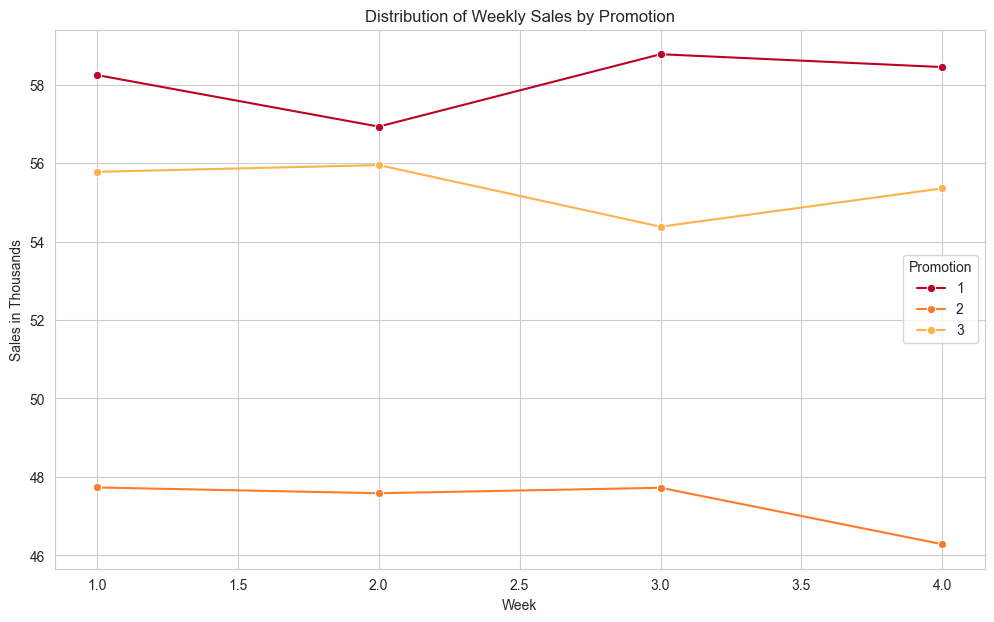

In [50]:
# Adjusting the violin plot without the 'split' parameter
colors = ['#bd0026', '#fc7c2c', '#feb24c']
def plot_weekly_sales(df):
    promotion_weekly = df.groupby(['promotion', 'week'])['salesinthousands'].mean().reset_index()
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=promotion_weekly, x='week', y='salesinthousands', hue='promotion', palette=colors, marker='o')
    plt.title('Distribution of Weekly Sales by Promotion')
    plt.xlabel('Week')
    plt.ylabel('Sales in Thousands')
    plt.legend(title='Promotion')
    plt.grid(True)
    plt.show()
plot_weekly_sales(df)

Promotion 3 is the most dynamic, showing significant growth and adaptability throughout the period, potentially due to factors like increased awareness. Promotion 1 recovers from a dip effectively, while Promotion 2 offers stability but less growth.

In [36]:
# For ANOVA, you need to compare the sales values across each promotion for each week.
f_val, p_val = stats.f_oneway(df[(df['promotion'] == 1)]['salesinthousands'],
                              df[(df['promotion'] == 2)]['salesinthousands'],
                              df[(df['promotion'] == 3)]['salesinthousands'])

print(f'ANOVA F-value: {f_val}, p-value: {p_val}')

ANOVA F-value: 21.953485793080677, p-value: 6.765849261408714e-10


The F-value is significantly high, and the small p-value (far below the typical significance level of 0.05) strongly suggests that there are significant differences in the average sales among the different promotions.

In [37]:
# Example for promotions 1 and 3:
mean1 = df[df['promotion'] == 1]['salesinthousands'].mean()
mean3 = df[df['promotion'] == 3]['salesinthousands'].mean()
std1 = df[df['promotion'] == 1]['salesinthousands'].std()
std3 = df[df['promotion'] == 3]['salesinthousands'].std()
n1 = df[df['promotion'] == 1]['salesinthousands'].count()
n3 = df[df['promotion'] == 3]['salesinthousands'].count()

# Mean difference (treatment effect)
mean_diff = mean3 - mean1

# Standard error of the difference in means
se_diff = np.sqrt(std1**2/n1 + std3**2/n3)

# 95% Confidence Interval
ci_low = mean_diff - 1.96 * se_diff
ci_high = mean_diff + 1.96 * se_diff

print(f'Mean Difference: {mean_diff}')
print(f'95% Confidence Interval: ({ci_low}, {ci_high})')

Mean Difference: -2.734543542800594
95% Confidence Interval: (-6.179034597609303, 0.7099475120081147)


The confidence interval ranges from approximately -6.1790 to 0.7099 thousand dollars. This interval includes zero, which suggests that the difference in average sales between the two promotions might not be statistically significant at the 95% confidence level.

In [38]:
# Extract sales data for Promotion 1 and Promotion 3
sales_promo1 = df[df['promotion'] == 1]['salesinthousands']
sales_promo3 = df[df['promotion'] == 3]['salesinthousands']

# Bootstrap Function
def bootstrap_mean_diff(data1, data2, n_bootstrap=10000):
    boot_means_diff = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        mean_dif = np.mean(sample2) - np.mean(sample1)
        boot_means_diff.append(mean_dif)
    return boot_means_diff

# Run bootstrap
bootstrap_diffs = bootstrap_mean_diff(sales_promo1, sales_promo3)

# Calculate the 95% confidence interval
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Output results
print(f'Bootstrap Mean Difference: {np.mean(bootstrap_diffs)}')
print(f'95% Confidence Interval: {confidence_interval}')

Bootstrap Mean Difference: -2.7232226594507667
95% Confidence Interval: [-6.22161102  0.66421478]


This indicates that, on average, Promotion 3 has sales that are approximately 2.74 thousand dollars less than those of Promotion 1, based on the bootstrap samples.

The confidence interval suggests that the true difference in sales between Promotions 3 and 1 could range from Promotion 3 underperforming Promotion 1 by as much as 6.23 thousand dollars to outperforming by about 0.69 thousand dollars. Importantly, this interval includes zero, indicating that the difference is not statistically significant at the 95% confidence level.

In [39]:
# Calculate p-value for the hypothesis that Promotion 3 has higher sales than Promotion 1
p_value = np.sum(np.array(bootstrap_diffs) > 0) / len(bootstrap_diffs)

print(f'P-value: {p_value}')

P-value: 0.0616


The p-value is slightly above the conventional threshold of 0.05 for statistical significance

Conclusion: Both analyses show a mean difference that is negative, indicating lower sales for Promotion 3 compared to Promotion 1. Both confidence intervals include zero, which suggests that neither analysis could demonstrate a statistically significant difference between the promotions’ performance.

# Performance by Age of Store

We’ll examine how the sales in thousands vary by the age of the store for each type of promotion.

In [40]:
# Create age bins and group by 'Promotion' and 'AgeOfStore' bins to compute average sales
df['ageofstorebins'] = pd.cut(df['ageofstore'], bins=[0, 5, 10, 15, 20, 100], labels=['0-5', '5-10', '10-15', '15-20', '20+'])

# Group by promotion and age bin
promotion_age_performance = df.groupby(['promotion', 'ageofstorebins'], observed=False)['salesinthousands'].mean().unstack()

promotion_age_performance

ageofstorebins,0-5,5-10,10-15,15-20,20+
promotion,,,,,
1,62.887639,55.732500,48.007188,63.560833,59.494167
2,45.772875,47.246563,49.887917,39.421250,58.303333
3,60.200882,46.546500,60.150000,65.056250,51.878500


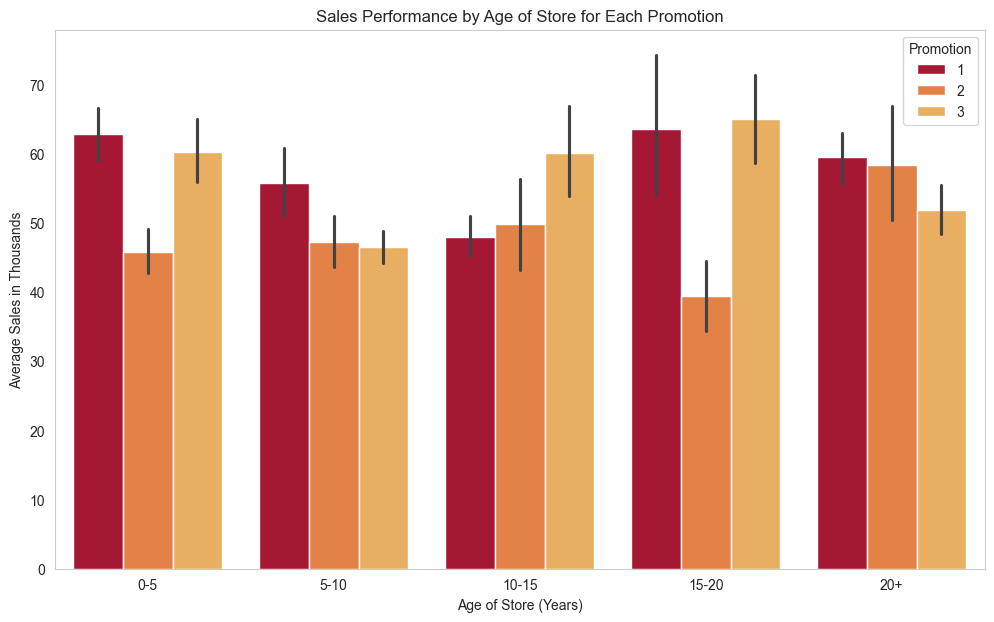

In [41]:
# Bar Plot for Sales Performance by Age of Store for Each Promotion
plt.figure(figsize=(12, 7))
sns.barplot(data=df, x='ageofstorebins', y='salesinthousands', hue='promotion', palette=colors)
plt.title('Sales Performance by Age of Store for Each Promotion')
plt.xlabel('Age of Store (Years)')
plt.ylabel('Average Sales in Thousands')
plt.legend(title='Promotion')
plt.grid(axis='y')
plt.show()

Promotion 1 and 3 appear to resonate better with either very new or older stores, might be due varying consumer demographics at these locations. Promotion 2's consistent yet lower performance might indicate a more generic approach that haven't leverage with store ages.

In [42]:
# Assuming there are 3 promotions
results = {}
for promo in df['promotion'].unique():
    groups = [df[(df['promotion'] == promo) & (df['ageofstorebins'] == bin)]['salesinthousands'].dropna() for bins in ['0-5', '5-10', '10-15', '15-20', '20+']]
    f_val, p_val = stats.f_oneway(*groups)
    results[promo] = (f_val, p_val)

# Display the results
for promo, result in results.items():
    print(f'Promotion {promo}: F-value = {result[0]}, p-value = {result[1]}')

Promotion 3: F-value = 8.88854764986004, p-value = 1.3983131942705182e-06
Promotion 2: F-value = 2.601495366073113, p-value = 0.037568523624695926
Promotion 1: F-value = 5.595323368464027, p-value = 0.00029876784683118283


Promotion 3 shows the most significant variation in effectiveness across different store ages, which might be due to the nature of the promotion being more sensitive to factors associated with the store’s demographic or physical condition.

Promotion 2, while still significant, shows the least sensitivity to store age.

Promotion 1 also shows significant variability in effectiveness across age bins, warranting a tailored strategy to optimize its implementation based on store age.

# Performance Based on Market Size

We’ll determine which promotion performs the best in different market sizes by averaging the sales in thousands.

In [43]:
# Group by 'Promotion' and 'MarketSize' to compute average sales for each market size for each promotion type
promotion_market_performance = df.groupby(['promotion', 'marketsize'])['salesinthousands'].mean().unstack()

promotion_market_performance

marketsize,Large,Medium,Small
promotion,,,
1,75.235893,47.672604,60.162500
2,60.322031,39.114352,50.810625
3,77.203958,45.468879,59.514167


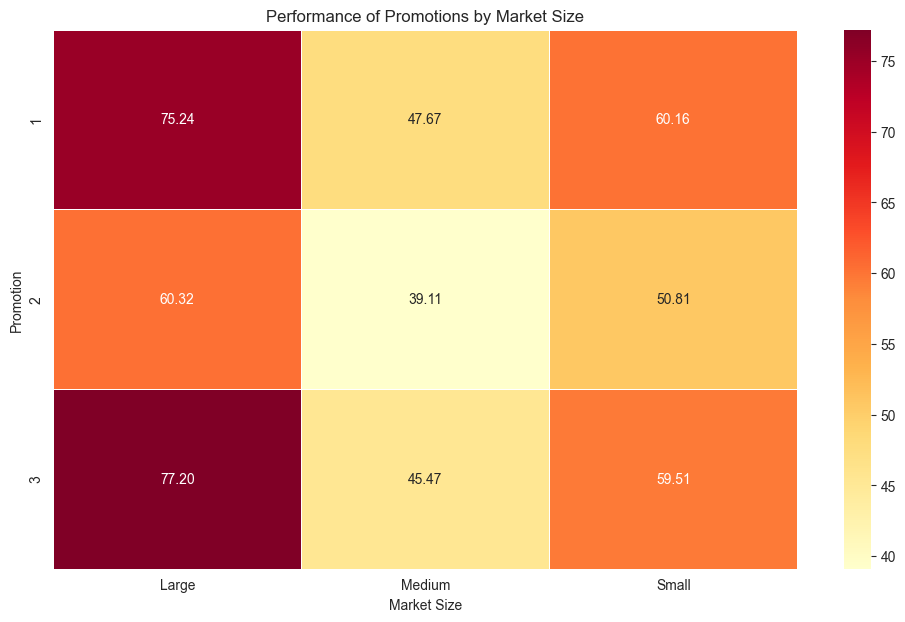

In [53]:
# Heatmap for Performance of Each Promotion in Different Market Sizes
def plot_heatmap(data):
    plt.figure(figsize=(12, 7))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=.5)
    plt.title('Performance of Promotions by Market Size')
    plt.xlabel('Market Size')
    plt.ylabel('Promotion')
    plt.show()
plot_heatmap(promotion_market_performance)

All promotions perform best in large market environments, possibly benefiting from greater customer bases or more substantial marketing resources. However, the steep drop in performance from large to small markets for Promotion 3 suggests a possible over-reliance on market size, whereas Promotion 1 slightly outperforms in Medium and Small markets.

In [45]:
# Assuming you have three market sizes: Large, Medium, Small
results = {}
for promo in df['promotion'].unique():
    groups = [df[(df['promotion'] == promo) & (df['marketsize'] == size)]['salesinthousands'].dropna() for size in ['Large', 'Medium', 'Small']]
    f_val, p_val = stats.f_oneway(*groups)
    results[promo] = (f_val, p_val)

# Display the results
for promo, result in results.items():
    print(f'Promotion {promo}: F-value = {result[0]}, p-value = {result[1]}')

Promotion 3: F-value = 179.13914752884793, p-value = 5.29440405719637e-44
Promotion 2: F-value = 69.31655634597757, p-value = 3.4157570723973646e-23
Promotion 1: F-value = 114.55557659624542, p-value = 3.597985579437392e-32


All three promotions show statistically significant variations in their effectiveness across different market sizes. Specifically, Promotion 3 shows the most sensitivity to market size, followed by Promotion 1, and then Promotion 2.

In [46]:
def calculate_bootstrap_means(data1, data2, n_bootstrap=1000):
    """Calculate bootstrap mean difference and 95% confidence interval."""
    boot_means = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        boot_means.append(sample1.mean() - sample2.mean())
    conf_interval = np.percentile(boot_means, [2.5, 97.5])
    mean_dif = np.mean(boot_means)
    return mean_dif, conf_interval

# Promotion 1: Large vs Small
data_large_p1 = df[(df['promotion'] == 1) & (df['marketsize'] == 'Large')]['salesinthousands']
data_small_p1 = df[(df['promotion'] == 1) & (df['marketsize'] == 'Small')]['salesinthousands']
mean_diff_p1, conf_interval_p1 = calculate_bootstrap_means(data_large_p1, data_small_p1)

# Promotion 3: Large vs Small
data_large_p3 = df[(df['promotion'] == 3) & (df['marketsize'] == 'Large')]['salesinthousands']
data_small_p3 = df[(df['promotion'] == 3) & (df['marketsize'] == 'Small')]['salesinthousands']
mean_diff_p3, conf_interval_p3 = calculate_bootstrap_means(data_large_p3, data_small_p3)

# Print results
print(f"Promotion 1 - Mean Difference: {mean_diff_p1}, 95% Confidence Interval: {conf_interval_p1}")
print(f"Promotion 3 - Mean Difference: {mean_diff_p3}, 95% Confidence Interval: {conf_interval_p3}")

Promotion 1 - Mean Difference: 15.007108464285713, 95% Confidence Interval: [10.2488875  19.57803929]
Promotion 3 - Mean Difference: 17.68638270833333, 95% Confidence Interval: [12.935625   22.20567708]


Both Promotion 1 and Promotion 3 are highly effective in increasing sales, with Promotion 3 showing a slightly higher mean difference.

# Overall Summary

View Food Marketing Dashboard here: https://lookerstudio.google.com/reporting/28545b28-b8dc-4674-8200-d1e4faadd33e

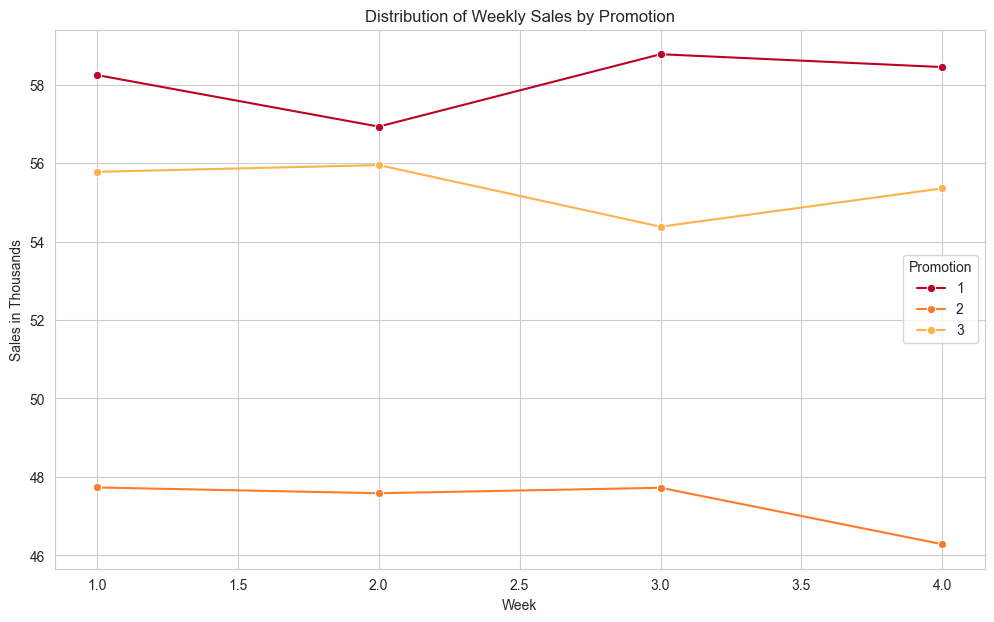

In [51]:
plot_weekly_sales(df)

Promotion 3 is ideal for dynamic, suitable for market environments where rapid growth is possible. It may require more nuanced strategies in smaller markets or could be paired with other initiatives to bolster its effectiveness in less populated areas.

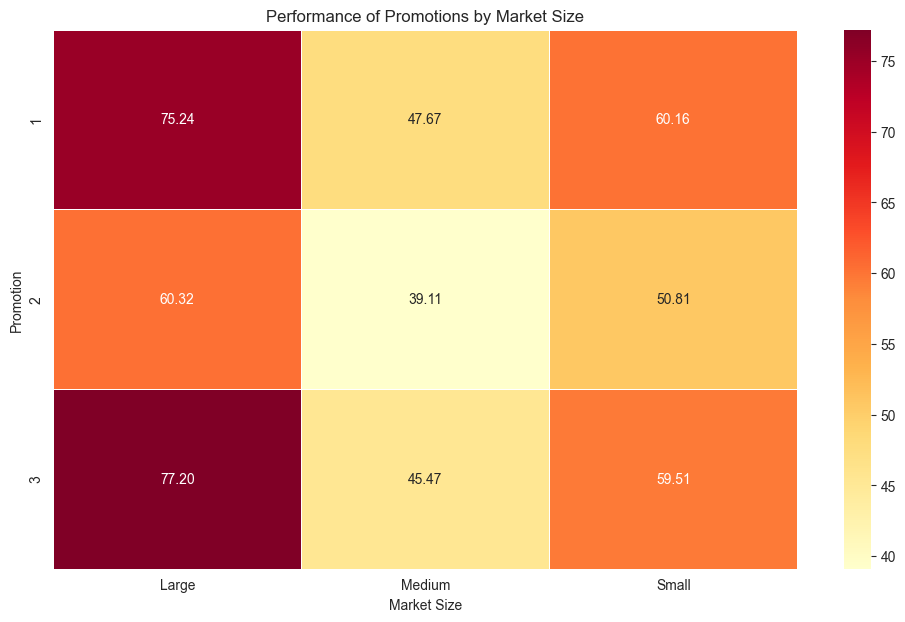

In [54]:
plot_heatmap(promotion_market_performance)

Promotion 1 is well-suited for large-scale market environments and could be particularly effective in launching new stores or rejuvenating older locations. Its ability to recover and grow suggests it could be aggressively marketed during periods of potential sales slumps.
    
Due to its stability, Promotion 2 could serve as a reliable year-round campaign across various store ages but might need additional support or customization in smaller markets. Its consistent performance makes it a safe choice for sustained, long-term marketing efforts.



## Suggestions

Consider economic variables such as seasonal purchasing patterns, and overall consumer spending trends.

Include customer age, gender, purchasing habits, and preferences to understand which segments are most responsive to each promotion.

Gather qualitative data from customers about why they responded to certain promotions or preferred certain store locations. This can add context to the quantitative data, offering deeper insights.

